# ML - Question 1

This file's texts are polished and (part of codes) commented by ChatGPT-4.

### Predict the potential sales of different genre/platforms/publishers of games, thus to find out which type of games will dominate the game market in recent futures.

Steps planned in this part of project:

1.   **Data Preprocessing**: Loading data, cleaning it (handling missing values, removing duplicates), and normalizing or scaling the features if necessary.

1.   **Exploratory Data Analysis (EDA)**: Visualize (extra ones from EDA milestone) the data to understand the distribution of sales across different genres, platforms/consoles, and publishers; identify any patterns or trends.

1.   **Feature Engineering**: Create new features that could help improve model's predictions.

1.   **Model Selection**: Choose appropriate models, including random forest and gradient boosting models.

  1.   **Hyperparameter Tuning**: For each model, select at least two different sets of hyper-parameters to compare performance (as required).

  1.   **Model Training and Validation**: Train models on a training set and validate them on a validation set.

  1.   **Model Evaluation**: Evaluate models on their performances.

1.   **Visualization of Results**: Visualize the model's performance and feature importances to interpret the results.

1.   **Conclusion**: Based on the model evaluations, conclude which game genres, platforms, and publishers are predicted to dominate the market.


## Data Preprocessing

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [2]:
# Load the data from the CSV file
df_sale = pd.read_csv('video game sales titles.csv')

# Display the first few rows
df_sale.head()


,Rank,Title,Console,Publisher,Developer,VGChartz Score,Critic Score,User Score,Total Sales,NA Sales,PAL Sales,Japan Sales,Other Sales,Release Date,Last Update,Genre
0,1,Wii Sports,Wii,Nintendo,Nintendo EAD,NaN,7.7,NaN,82900000.0,NaN,NaN,NaN,NaN,11/19/2006,NaN,Sports
1,2,Mario Kart 8 Deluxe,NS,Nintendo,Nintendo EPD,NaN,9.3,NaN,55460000.0,NaN,NaN,NaN,NaN,4/28/2017,11/19/2018,Racing
2,3,Animal Crossing: New Horizons,NS,Nintendo,Nintendo,8.0,NaN,NaN,42790000.0,NaN,NaN,NaN,NaN,3/20/2020,4/11/2020,Simulation
3,4,Super Mario Bros.,NES,Nintendo,Nintendo EAD,NaN,10.0,8.2,40240000.0,NaN,NaN,NaN,NaN,10/18/1985,NaN,Platform
4,5,Counter-Strike: Global Offensive,PC,Valve,Valve Corporation,NaN,NaN,NaN,40000000.0,NaN,NaN,NaN,NaN,8/21/2012,3/26/2019,Shooter


In [3]:
# Fill missing values for 'Critic Score', 'User Score' and 'VGChartz Score' with their respective means
df_sale['Critic Score'].fillna(df_sale['Critic Score'].mean(), inplace=True)
df_sale['User Score'].fillna(df_sale['User Score'].mean(), inplace=True)
df_sale['VGChartz Score'].fillna(df_sale['VGChartz Score'].mean(), inplace=True)


# Fill missing values for sales data with zeros
sales_columns = ['NA Sales', 'PAL Sales', 'Japan Sales', 'Other Sales']
df_sale[sales_columns] = df_sale[sales_columns].fillna(0)

# Extract the relevant features for prediction
features = df_sale[['Console', 'Publisher', 'Genre', 'Critic Score', 'User Score']]

# We also need to extract the target variable 'Total Sales'
target = df_sale['Total Sales']

The steps performed are as follows:

**Missing Values Handling**: Missing values in 'Critic Score' and 'User Score' have been filled with their respective column means, which allows us to retain these rows for our analysis without discarding them. Sales columns with missing values were filled with zero, assuming that missing values could imply no sales.

**Scaling**: The 'Critic Score' and 'User Score' have been standardized using StandardScaler, which centers the data around zero with a standard deviation of one. This is important to ensure that the scale of the scores does not affect the algorithms disproportionately.

**One-Hot Encoding**: The categorical features 'Console', 'Publisher', and 'Genre' have been one-hot encoded, converting them into a format that machine learning algorithms can work with.

## EDA

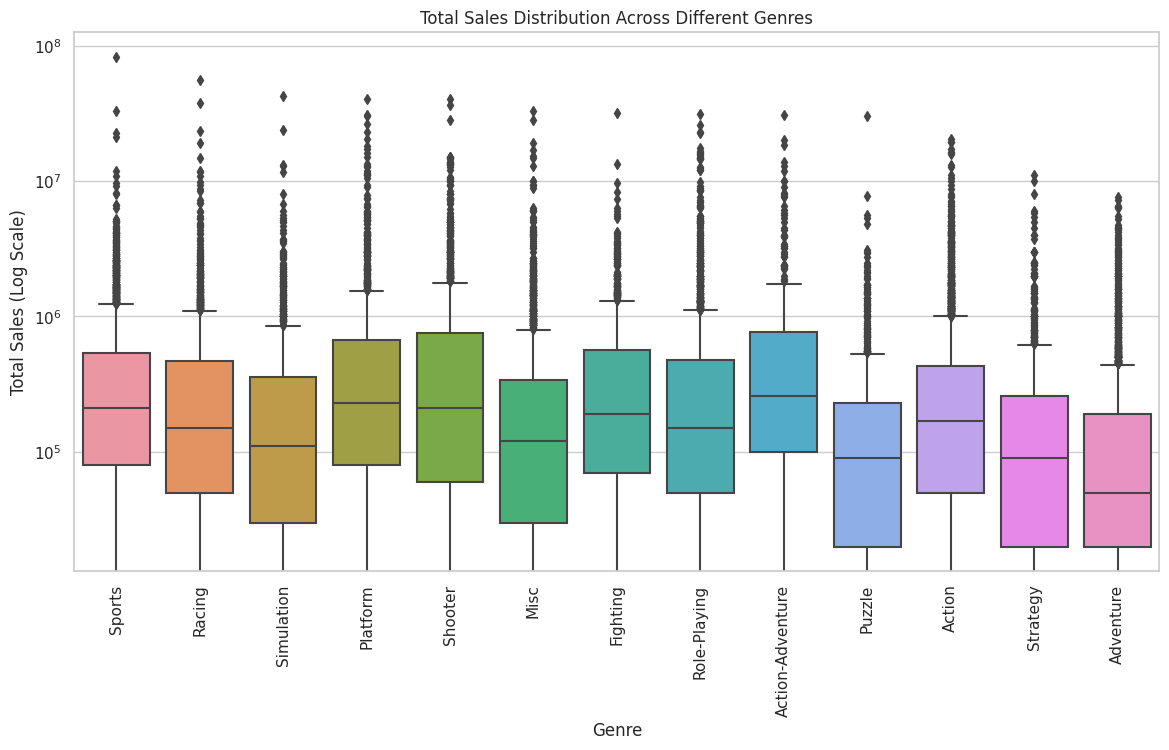

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check no duplicates in the data
df_sale.drop_duplicates(inplace=True)

# Check for any duplicates after dropping
duplicates = df_sale.duplicated().sum()

# Set up the aesthetics for the plots
sns.set(style="whitegrid")

# Total Sales distribution across Genres
plt.figure(figsize=(14, 7))
sns.boxplot(data=df_sale, x='Genre', y='Total Sales')
plt.xticks(rotation=90)
plt.title('Total Sales Distribution Across Different Genres')
plt.yscale('log')  # Use logarithmic scale due to large range of sales
plt.ylabel('Total Sales (Log Scale)')
plt.xlabel('Genre')
plt.show()

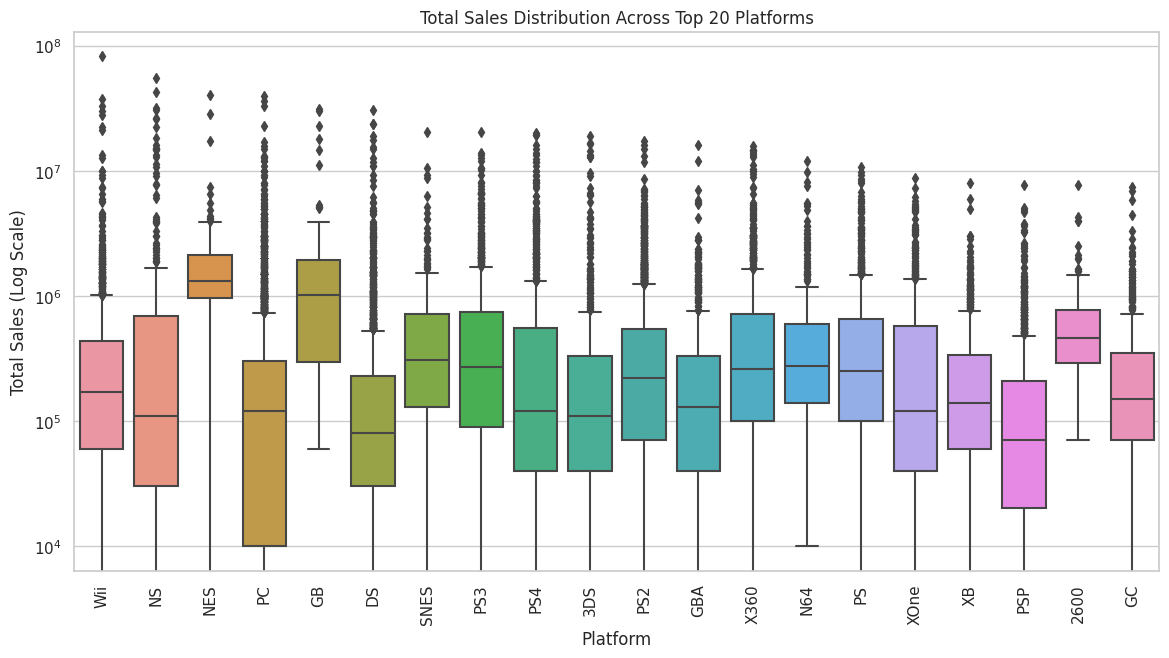

In [5]:
# Total Sales distribution across Platforms
# Given there may be a large number of publishers, we'll focus on the top 20 by total sales
top_platforms = df_sale.groupby('Console')['Total Sales'].sum().sort_values(ascending=False).head(20).index
df_top_platforms = df_sale[df_sale['Console'].isin(top_platforms)]
plt.figure(figsize=(14, 7))
sns.boxplot(data=df_top_platforms, x='Console', y='Total Sales')
plt.xticks(rotation=90)
plt.title('Total Sales Distribution Across Top 20 Platforms')
plt.yscale('log')  # Use logarithmic scale due to large range of sales
plt.ylabel('Total Sales (Log Scale)')
plt.xlabel('Platform')
plt.show()

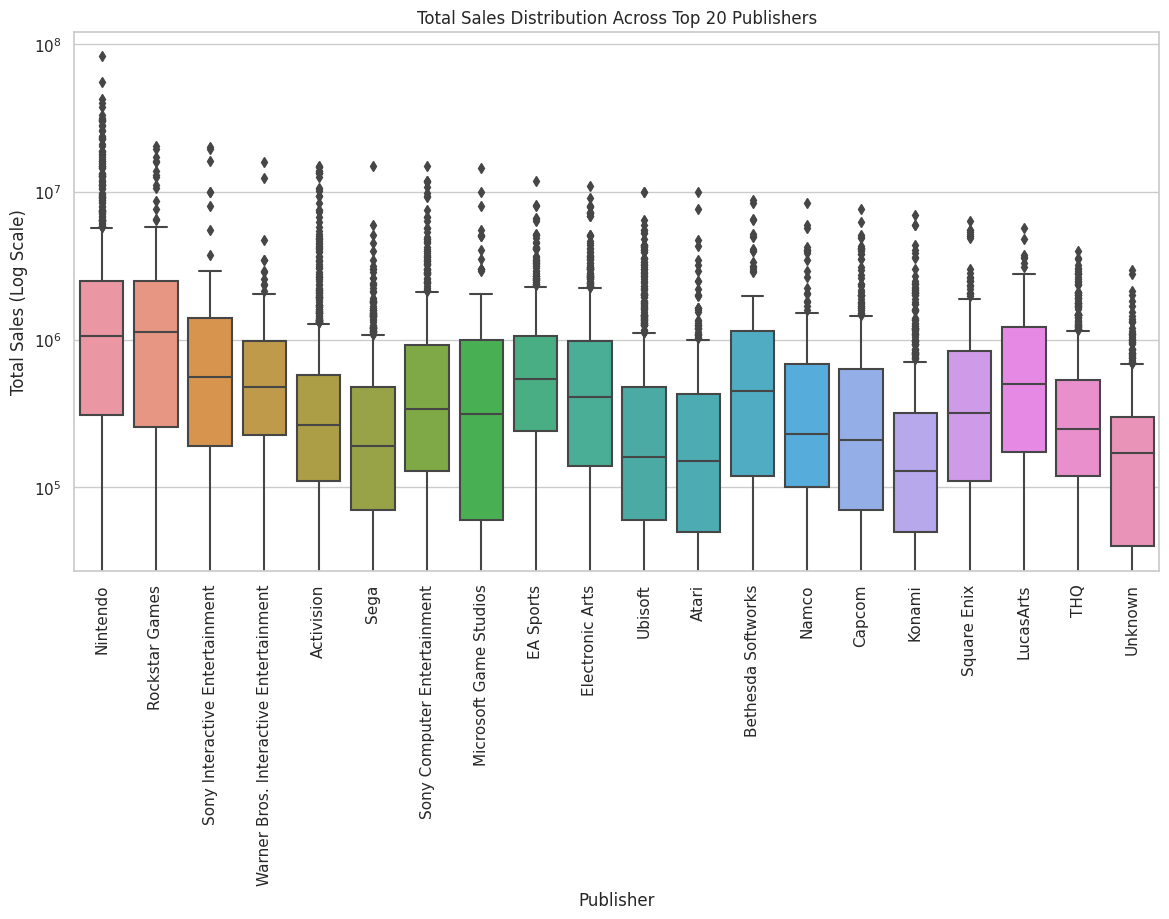

In [6]:
# Total Sales distribution across Publishers
# Given there may be a large number of publishers, focus only on the top 20 by total sales
top_publishers = df_sale.groupby('Publisher')['Total Sales'].sum().sort_values(ascending=False).head(20).index
df_top_publishers = df_sale[df_sale['Publisher'].isin(top_publishers)]
plt.figure(figsize=(14, 7))
sns.boxplot(data=df_top_publishers, x='Publisher', y='Total Sales')
plt.xticks(rotation=90)
plt.title('Total Sales Distribution Across Top 20 Publishers')
plt.yscale('log')  # Use logarithmic scale due to large range of sales
plt.ylabel('Total Sales (Log Scale)')
plt.xlabel('Publisher')
plt.show()

<ipython-input-7-735e67515d37>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_sale, x='Year', y='Total Sales', estimator=sum, ci=None)


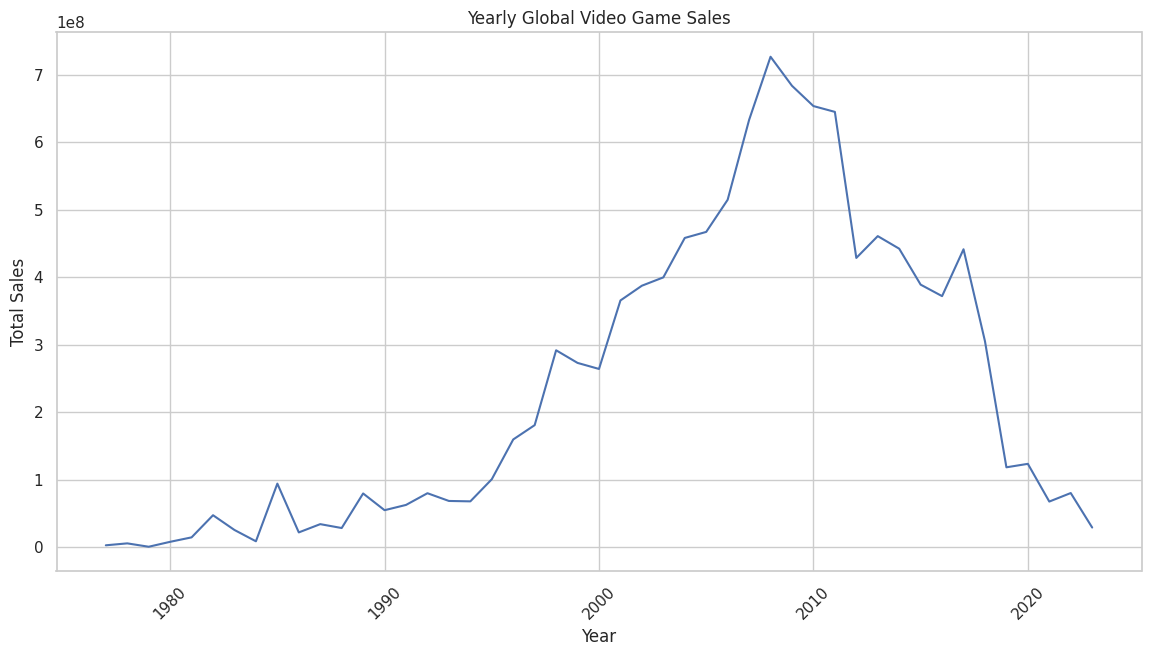

In [7]:
# Sales trends over the years
plt.figure(figsize=(14, 7))
df_sale['Year'] = pd.to_datetime(df_sale['Release Date']).dt.year  # Extract year from release date
sns.lineplot(data=df_sale, x='Year', y='Total Sales', estimator=sum, ci=None)
plt.xticks(rotation=45)
plt.title('Yearly Global Video Game Sales')
plt.ylabel('Total Sales')
plt.xlabel('Year')
plt.show()

<ipython-input-8-7471974e4ee9>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_sale.corr()


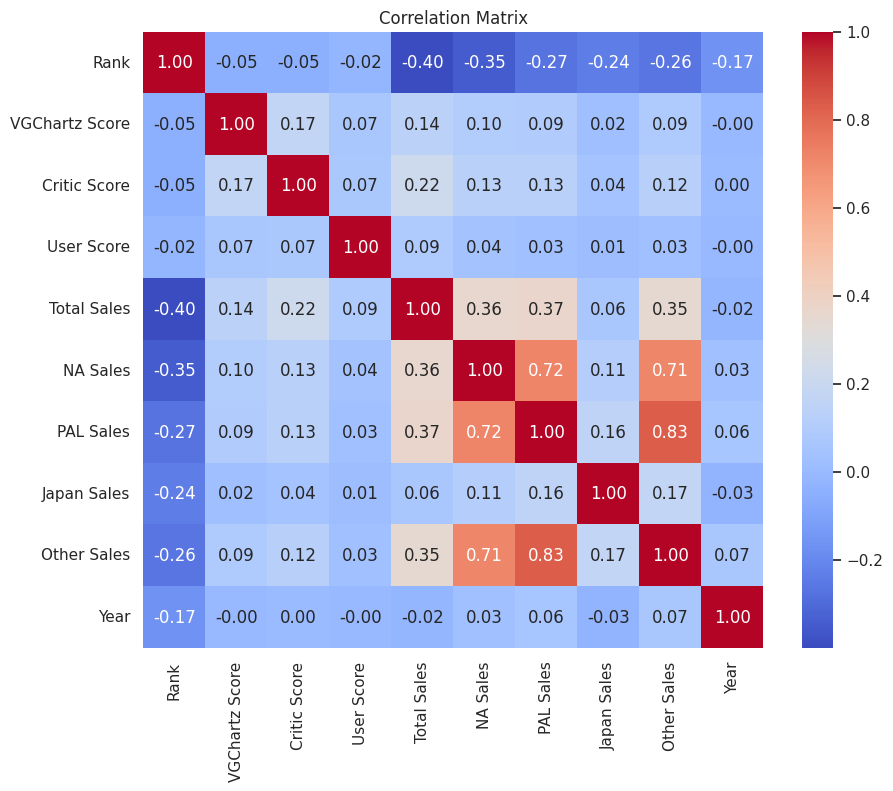

In [8]:
# Correlation matrix
corr_matrix = df_sale.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Feature Engineering

This part of codes is helped and debugged from ChatGPT-4

For the feature engineering step, we followed this process:

**Temporal Features**:

Convert the 'Release Date' column to datetime if not already done.
Extract the year, month, and possibly the quarter from the 'Release Date' to use as new features.

**Sales Ratios**:

Calculate the ratios of regional sales to total sales to capture regional preferences.

**Interaction Terms**:

Use one-hot encoding to convert 'Genre' and 'Console' to a numerical format.
Create interaction terms between the one-hot encoded genres and consoles using PolynomialFeatures with interaction_only=True.
Be cautious with the number of interaction terms due to the combinatorial increase in features.


In [9]:
from sklearn.preprocessing import PolynomialFeatures

# Convert 'Release Date' to datetime and extract temporal features
df_sale['Year'] = pd.to_datetime(df_sale['Release Date']).dt.year
df_sale['Month'] = pd.to_datetime(df_sale['Release Date']).dt.month
df_sale['Quarter'] = pd.to_datetime(df_sale['Release Date']).dt.quarter

# Calculate the sales ratios
df_sale['NA_Sales_Ratio'] = df_sale['NA Sales'] / df_sale['Total Sales']
df_sale['PAL_Sales_Ratio'] = df_sale['PAL Sales'] / df_sale['Total Sales']
df_sale['Japan_Sales_Ratio'] = df_sale['Japan Sales'] / df_sale['Total Sales']
df_sale['Other_Sales_Ratio'] = df_sale['Other Sales'] / df_sale['Total Sales']

# Replace any potential infinities or NaNs from division by zero with zeros
df_sale.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from scipy.sparse import hstack, csr_matrix
from itertools import product

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Critic Score', 'User Score']),  # Standardize the numeric columns
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), ['Console', 'Publisher', 'Genre'])  # One-hot encode the categorical columns
    ],
    remainder='drop'  # Drop all other columns that are not explicitly transformed
)

# Fit and transform the features using the preprocessor
features = df_sale[['VGChartz Score', 'Critic Score', 'User Score', 'Console', 'Publisher', 'Genre']]  # Specify the columns to be used
X_preprocessed_sparse = preprocessor.fit_transform(features)

# Retrieve the one-hot encoded feature names for 'Console' and 'Genre'
onehot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out()

# Find the indices for the 'Console' and 'Genre' features after one-hot encoding
console_mask = np.array(['Console' in feature for feature in onehot_feature_names])
genre_mask = np.array(['Genre' in feature for feature in onehot_feature_names])

# Initialize a list to store the interaction term matrices
interaction_terms_list = []

# Generate interaction terms only between 'Console' and 'Genre'
# Use the boolean masks to select the corresponding columns
console_features = X_preprocessed_sparse[:, console_mask]
genre_features = X_preprocessed_sparse[:, genre_mask]

# Now multiply each console feature with each genre feature
# The result is a set of interaction terms which we can add to the interaction_terms_list
for console_idx in range(console_features.shape[1]):
    for genre_idx in range(genre_features.shape[1]):
        interaction_term = console_features[:, console_idx].multiply(genre_features[:, genre_idx])
        interaction_terms_list.append(interaction_term)

# Ensure that the interaction_terms_list is not empty before stacking
if interaction_terms_list:
    # Combine all the interaction terms into a single sparse matrix
    interaction_terms_sparse = hstack(interaction_terms_list)

    # Combine the original preprocessed features with the interaction terms
    X_final = hstack([X_preprocessed_sparse, interaction_terms_sparse])
else:
    # If no interaction terms, the final matrix is just the preprocessed features
    X_final = X_preprocessed_sparse

## Model Selection

Given the nature of the dataset and the task, we will use:

Random Forest Regressor: A versatile ensemble learning method capable of capturing complex nonlinear relationships through multiple decision trees.

Gradient Boosting Regressor: Another powerful ensemble technique that builds trees in a sequential manner, where each tree tries to correct the errors of the previous ones.



In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_final, df_sale['Total Sales'], test_size=0.2, random_state=42)

# Initialize the models
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Train the Gradient Boosting model
gb_model.fit(X_train, y_train)

# Predict on the validation set
rf_valid_predictions = rf_model.predict(X_valid)
gb_valid_predictions = gb_model.predict(X_valid)

# Calculate the evaluation metrics for the Random Forest model
rf_mae = mean_absolute_error(y_valid, rf_valid_predictions)
rf_rmse = mean_squared_error(y_valid, rf_valid_predictions, squared=False)
rf_r2 = r2_score(y_valid, rf_valid_predictions)

# Calculate the evaluation metrics for the Gradient Boosting model
gb_mae = mean_absolute_error(y_valid, gb_valid_predictions)
gb_rmse = mean_squared_error(y_valid, gb_valid_predictions, squared=False)
gb_r2 = r2_score(y_valid, gb_valid_predictions)

# Output the metrics
rf_metrics = {'MAE': rf_mae, 'RMSE': rf_rmse, 'R^2': rf_r2}
gb_metrics = {'MAE': gb_mae, 'RMSE': gb_rmse, 'R^2': gb_r2}

rf_metrics, gb_metrics


({'MAE': 197619.35856331457,
  'RMSE': 897140.8051864719,
  'R^2': 0.1420260074555597},
 {'MAE': 245365.55734752212,
  'RMSE': 899660.8047964071,
  'R^2': 0.13719927191484582})

Random Forest Regressor has a Mean Absolute Error (MAE) of approximately 197,619, a Root Mean Squared Error (RMSE) of approximately 897,141, and an R² score of about 0.142.
Gradient Boosting Regressor has an MAE of approximately 245,366, an RMSE of approximately 899,661, and an R² score of about 0.137.

#### Interpretation of Results:
**MAE (Mean Absolute Error)**: This is the average absolute difference between the predicted values and the actual values. Lower MAE values are better. The Random Forest model has a lower MAE, suggesting that on average, its predictions are closer to the actual sales figures than those of the Gradient Boosting model.

**RMSE (Root Mean Squared Error)**: This metric gives us an idea of the magnitude of the error. It is more sensitive to large errors than MAE because it squares the errors before averaging them. The RMSE values are quite high for both models, suggesting that there are significant errors in the predictions. Both models have similar RMSE values.

**R² (R-squared)**: This is the coefficient of determination, which measures the proportion of variance in the dependent variable that is predictable from the independent variables. An R² score of 1 indicates perfect prediction. Both models have a low R² score, indicating that they are not explaining much of the variance in the data.


### Improving Model Performance

Hyperparameter Tuning

This code block defines a grid of hyperparameters to explore for each model and then performs a randomized search with cross-validation to find the best combination of parameters.

In [17]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 50, 100, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Hyperparameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# Randomized search for Random Forest
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_grid, n_iter=10, cv=3, random_state=42)
rf_random_search.fit(X_train, y_train)

# Randomized search for Gradient Boosting
gb_random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=gb_param_grid, n_iter=10, cv=3, random_state=42)
gb_random_search.fit(X_train, y_train)

# Best parameters from random search
rf_best_params = rf_random_search.best_params_
gb_best_params = gb_random_search.best_params_

rf_best_params, gb_best_params


({'n_estimators': 200,
  'min_samples_split': 2,
  'min_samples_leaf': 4,
  'max_depth': 100,
  'bootstrap': True},
 {'subsample': 0.9,
  'n_estimators': 200,
  'min_samples_split': 10,
  'min_samples_leaf': 4,
  'max_features': None,
  'max_depth': 3,
  'learning_rate': 0.2})

With the best parameters identified for both the Random Forest (rf_best_params) and Gradient Boosting (gb_best_params) models, we can proceed to the next steps. These involve retraining the models with these optimized hyperparameters, validating them on the validation set, and evaluating their performance using metrics like MAE, RMSE, and R² score.

Let's train the models with the best parameters and evaluate them:

In [18]:
# Retrain the models with the best parameters found from hyperparameter tuning
rf_best_model = RandomForestRegressor(**rf_best_params, random_state=42)
gb_best_model = GradientBoostingRegressor(**gb_best_params, random_state=42)

# Train the Random Forest model with the best parameters
rf_best_model.fit(X_train, y_train)

# Train the Gradient Boosting model with the best parameters
gb_best_model.fit(X_train, y_train)

# Predict on the validation set with the optimized models
rf_best_valid_predictions = rf_best_model.predict(X_valid)
gb_best_valid_predictions = gb_best_model.predict(X_valid)

# Calculate the evaluation metrics for the optimized Random Forest model
rf_best_mae = mean_absolute_error(y_valid, rf_best_valid_predictions)
rf_best_rmse = mean_squared_error(y_valid, rf_best_valid_predictions, squared=False)
rf_best_r2 = r2_score(y_valid, rf_best_valid_predictions)

# Calculate the evaluation metrics for the optimized Gradient Boosting model
gb_best_mae = mean_absolute_error(y_valid, gb_best_valid_predictions)
gb_best_rmse = mean_squared_error(y_valid, gb_best_valid_predictions, squared=False)
gb_best_r2 = r2_score(y_valid, gb_best_valid_predictions)

# Output the metrics for the optimized models
rf_best_metrics = {'MAE': rf_best_mae, 'RMSE': rf_best_rmse, 'R^2': rf_best_r2}
gb_best_metrics = {'MAE': gb_best_mae, 'RMSE': gb_best_rmse, 'R^2': gb_best_r2}

rf_best_metrics, gb_best_metrics


({'MAE': 207219.12945297884,
  'RMSE': 883105.5865183055,
  'R^2': 0.16866097673119063},
 {'MAE': 241517.87815018202,
  'RMSE': 903432.2500328239,
  'R^2': 0.1299502594072589})

## Visualize results and Interpret models

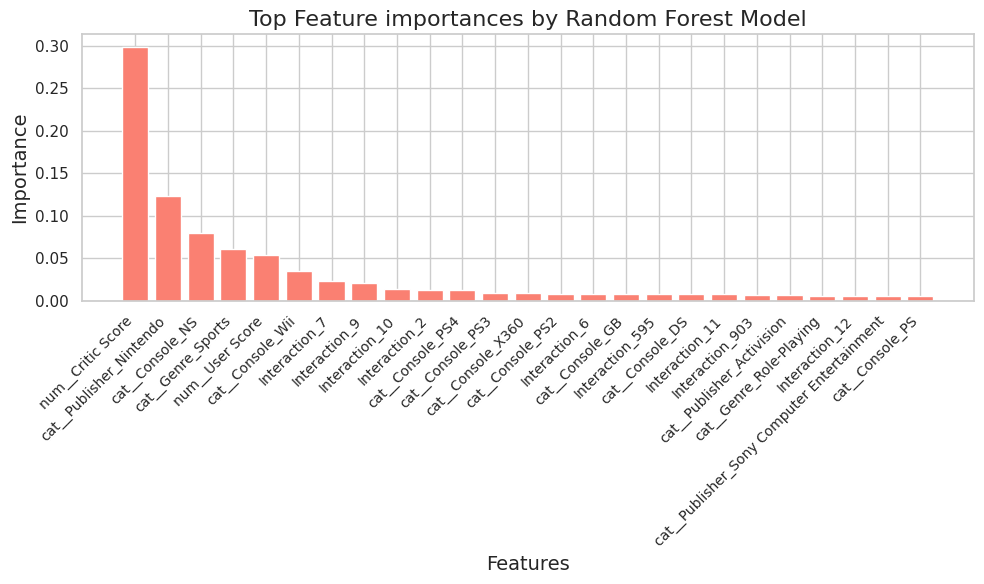

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Feature Importances Visualization for Random Forest
feature_names = preprocessor.get_feature_names_out()  # Get the feature names after preprocessing
rf_importances = rf_best_model.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]  # Sort feature importances in descending order

# Assemble a complete list of feature names that includes both the original features and the interaction terms.
interaction_feature_names = ['Interaction_' + str(i) for i in range(X_train.shape[1] - len(feature_names))]

# Combine the original feature names with the interaction feature names
all_feature_names = np.concatenate([feature_names, interaction_feature_names])

# Full set of feature names
rf_indices = np.argsort(rf_importances)[::-1]  # Indices of features in order of importance

# Number of top features
top_n_features = 25

# Sort feature importances in descending order and select the top N
sorted_indices = np.argsort(rf_importances)[::-1][:top_n_features]
sorted_importances = rf_importances[sorted_indices]
sorted_feature_names = np.array(all_feature_names)[sorted_indices]

# Plot the feature importances of the forest for the top N features
plt.figure(figsize=(10, 6))
plt.title("Top Feature importances by Random Forest Model", fontsize=16)
plt.bar(range(top_n_features), sorted_importances, color="salmon", align="center")
plt.xticks(range(top_n_features), sorted_feature_names, rotation=45, ha='right', fontsize=10)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()


#### Interpretation of the plot:

*  Critic Score: This is the most significant predictor of game sales in the dataset, with the highest importance by a substantial margin. It suggests that games with higher critical acclaim are likely to sell better. This might be due to the influence of critics on consumer purchasing decisions or because high scores are correlated with game quality.

*  Publisher Nintendo: The specific publisher "Nintendo" stands out among others, indicating that games published by Nintendo tend to have more predictable and possibly higher sales. This could reflect Nintendo's brand strength, loyal customer base, or successful marketing strategies.

*  Console Sports: The genre "Sports" when associated with a particular console (the name of the console is not visible in the snippet provided) is a significant predictor. This implies that sports games perform notably well on this console, which could be due to the console's user demographic or the popularity of sports games among its users.

*  User Score: This feature, while important, is less so compared to the critic score, indicating that while user opinions matter, professional reviews are a stronger sales driver.

*  Interaction Terms: These terms, such as "Interaction_1", "Interaction_9", etc., represent the combined effect of two features (like a specific console and genre pairing) on game sales. Their presence among the top features suggests that certain combinations have a notable impact on sales, beyond what would be predicted by considering each feature in isolation. For instance, a specific genre of game might sell particularly well on one console but not on another.

*  Console Wii: This implies that the Wii console itself is a strong predictor, which could be due to its unique market position, demographic appeal, or the success of specific titles that drive hardware sales.

*  Genre Action: The action genre alone is a significant predictor, which suggests that action games have a consistent pattern of sales across various platforms.

*  Publisher Sony Computer Entertainment: Similar to Nintendo, Sony Computer Entertainment as a publisher is a key predictor, indicating the strength of its brand and the success of its games.

From this visualization, it is evident that a mix of critic opinions, user opinions, the reputation of publishers, and the compatibility of game genres with specific consoles are all critical factors in predicting video game sales. The exact nature of the interaction terms would need further examination to fully understand how they combine to influence sales predictions.

The presence of interaction terms among the top features also underscores the value of including these in the model; they capture relationships that individual features alone do not. This type of insight can be particularly useful for game developers and publishers when planning new game releases or marketing strategies.

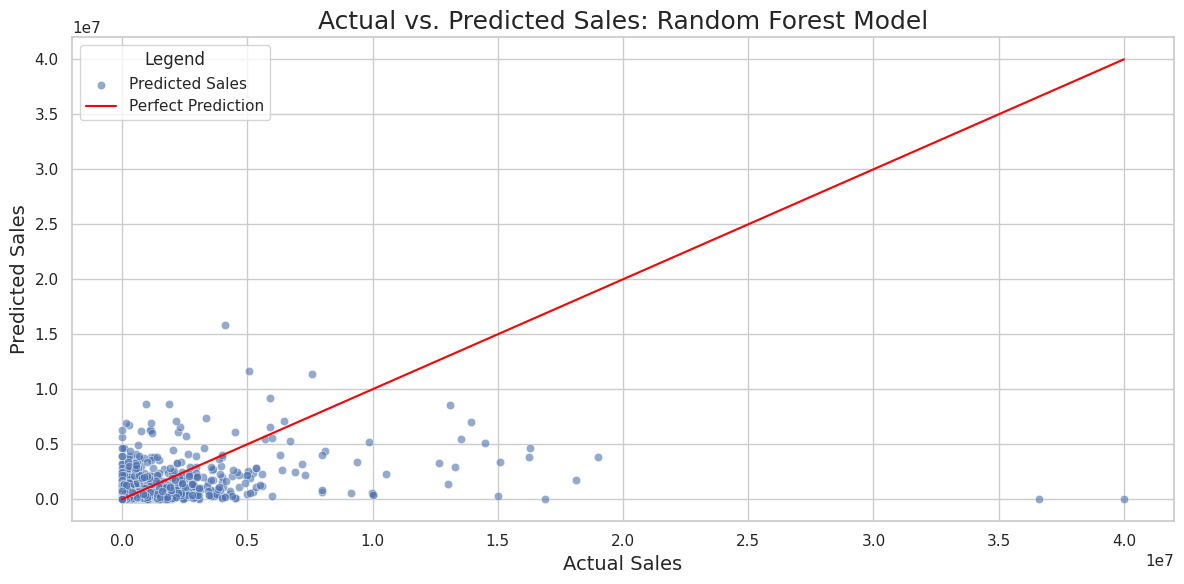

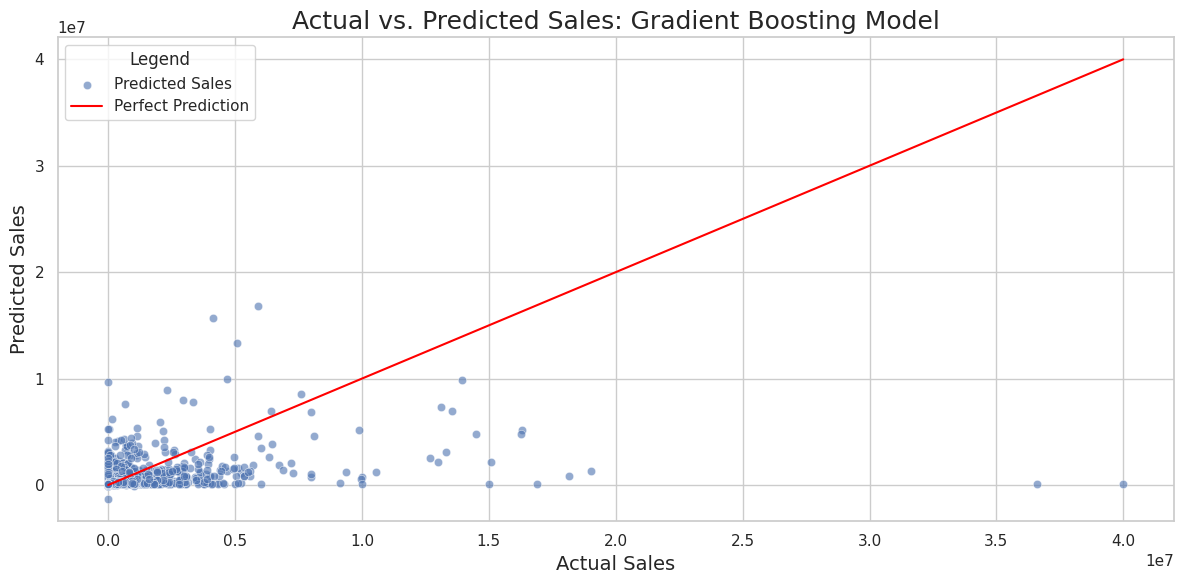

In [32]:
# Predictions vs Actual Sales Visualization
# For simplicity, take a random subset of the validation set to make the plot more readable
sample_size = 10000
random_indices = np.random.choice(X_valid.shape[0], sample_size, replace=False)

# Actual vs. Predicted Sales for Random Forest
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_valid.iloc[random_indices], y=rf_best_valid_predictions[random_indices], alpha=0.6, label='Predicted Sales')
sns.lineplot(x=y_valid.iloc[random_indices], y=y_valid.iloc[random_indices], color='red', label='Perfect Prediction')
plt.title('Actual vs. Predicted Sales: Random Forest Model', fontsize=18)
plt.xlabel('Actual Sales', fontsize=14)
plt.ylabel('Predicted Sales', fontsize=14)
plt.legend(title='Legend')  # Add a legend with title
plt.tight_layout()
plt.show()

# Actual vs. Predicted Sales for Gradient Boosting
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_valid.iloc[random_indices], y=gb_best_valid_predictions[random_indices], alpha=0.6, label='Predicted Sales')
sns.lineplot(x=y_valid.iloc[random_indices], y=y_valid.iloc[random_indices], color='red', label='Perfect Prediction')
plt.title('Actual vs. Predicted Sales: Gradient Boosting Model', fontsize=18)
plt.xlabel('Actual Sales', fontsize=14)
plt.ylabel('Predicted Sales', fontsize=14)
plt.legend(title='Legend')  # Add a legend with title
plt.tight_layout()
plt.show()


#### Random Forest Model Plot

The first plot shows a scatter of predicted versus actual sales from the Random Forest model. The red line represents a "perfect prediction" where the predicted sales exactly match the actual sales. Points along this line are accurate predictions.

**Dense Clustering Near Origin**: Most predictions are clustered near the origin, suggesting that for lower sales figures, the model's predictions are relatively close to actual sales.

**Spread of Points**: The spread of points away from the perfect prediction line indicates prediction errors. The further a point is from the line, the larger the error.

**Outliers**: There are points far from the origin, which are likely high-selling games. The model does not predict these as accurately, as indicated by the distance from the perfect prediction line.

#### Gradient Boosting Model Plot

The second plot shows the predicted versus actual sales from the Gradient Boosting model, with a similar interpretation:

**Similar Dense Clustering**: Like the Random Forest model, most predictions are close to the origin, which indicates smaller errors for games with lower sales.

**Prediction Errors**: There is a similar spread of points indicating varying degrees of prediction error.

**High-Sales Games**: This model also seems to struggle with accurately predicting the very high-selling games, as the points for high actual sales deviate from the perfect prediction line.

### Overall Interpretation

For both models, the predictions for games with lower sales are more accurate than those for games with higher sales. This could be due to several factors:

**Outliers**: High-sales games might be outliers in the dataset, and since these models rely on patterns learned from the majority of the data, the models may not capture the exceptional circumstances that lead to very high sales.

**Feature Representation**: The features used to train the model may not adequately capture the factors that cause a game to be a top seller.

**Data Imbalance**: If the dataset contains many more low-sales games than high-sales ones, the models will be biased towards predicting lower sales figures.